In [1]:
import os
import random
import numpy as np
import shutil
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations

random.seed(1234)
idx = random.sample(range(853), 170)

#for img in np.array(sorted(os.listdir('images')))[idx]:
#    shutil.move('images/'+img, 'test_images/'+img)

#for annot in np.array(sorted(os.listdir('annotations')))[idx]:
#    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti
683
683


하위 디렉터리 또는 파일 test_images이(가) 이미 있습니다.
하위 디렉터리 또는 파일 test_annotations이(가) 이미 있습니다.


In [2]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [3]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [4]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [5]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

Face Mask Detection에 전이 학습을 실시해 보겠습니다. Face Mask Detection 데이터셋은 3개의 클래스로 이루어져 있지만 background 클래스를 포함하여 num_classes를 4로 설정한 후 모델을 불러옵니다.

GPU를 사용할 수 있는 환경이라면 device로 지정하여 불러온 모델을 GPU에 보내줍니다.

In [6]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [7]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [8]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 56.10851287841797, time : 125.17095613479614
epoch : 2, Loss : 31.84865379333496, time : 131.82628226280212
epoch : 3, Loss : 25.378490447998047, time : 131.20952773094177
epoch : 4, Loss : 21.045194625854492, time : 131.16197228431702
epoch : 5, Loss : 18.055402755737305, time : 131.18859338760376
epoch : 6, Loss : 16.216707229614258, time : 131.61938858032227
epoch : 7, Loss : 15.481952667236328, time : 131.5808186531067
epoch : 8, Loss : 14.898301124572754, time : 131.57584810256958
epoch : 9, Loss : 13.600943565368652, time : 131.10602474212646
epoch : 10, Loss : 12.949697494506836, time : 131.6492908000946


In [9]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [10]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [11]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[216.3836,  59.1389, 252.0742, 100.6325],
        [117.6326,   1.9920, 132.7718,  19.3265]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9890, 0.9826], device='cuda:0')}, {'boxes': tensor([[ 41.3702, 108.4371,  67.1249, 142.2197],
        [133.4110, 108.9091, 176.9745, 153.3411],
        [219.7171,  99.3325, 257.8406, 138.0114],
        [ 29.5790,  89.0902,  45.7187, 104.4446],
        [164.9198,  89.4592, 179.9225, 110.1062],
        [302.6541, 129.8430, 332.8004, 158.9621],
        [ 82.9750,  84.5991,  94.8416,  97.8954],
        [  2.6865, 104.1182,  22.4588, 127.5102],
        [258.5313,  90.9648, 269.2581, 102.2767]], device='cuda:0'), 'labels': tensor([1, 2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.9965, 0.9962, 0.9960, 0.9957, 0.9954, 0.9756, 0.9638, 0.7713],
       device='cuda:0')}]


{'boxes': tensor([[ 42., 109.,  66., 140.],
        [  2., 105.,  22., 125.],
        [ 30.,  88.,  46., 105.],
        [133., 108., 174., 152.],
        [221., 101., 256., 139.],
        [304., 131., 331., 158.],
        [ 83.,  85.,  96.,  96.],
        [167.,  91., 180., 108.]]), 'labels': tensor([1, 1, 1, 2, 2, 1, 1, 1])}
Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


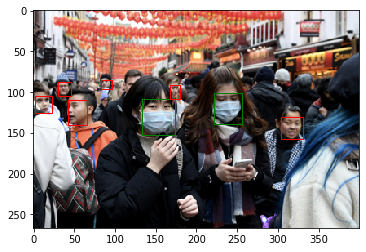

Prediction :  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1])


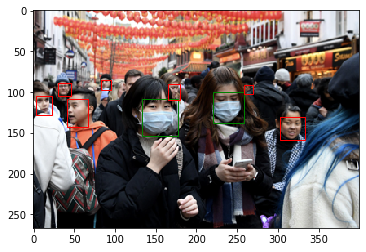

In [92]:
_idx = 1 # annotations 는 튜플 'boxes' tensor [ 좌표], 'labels' tensor [클래스]
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'].to("cpu"))
#pred_cpu = pred[_idx]['labels'].cpu()#.data.numpy().argmax()
#PATH = f'pred_model{num_epochs}.pt'
#torch.save(pred[_idx].state_dict(),PATH )
#pred_cpu = pred[_idx]
#pred_cpu.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
zz = {'boxes':pred[_idx]['boxes'].to("cpu") ,'labels':pred[_idx]['labels'].to("cpu")}
plot_image_from_output(imgs[_idx],zz)

In [98]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot
    print(annot)
    #train_examples = []
    #for item in annot:
    #    in_tensor = torch.Tensor(item['boxes'])
    #    out_tensor = torch.LongTensor(item['labels'])
    #    train_examples.append([in_tensor, out_tensor])
    #print(train_examples)
 # tensor to list
    for t in annot:
        print(t['labels'])
        labels += t['labels'].to("cpu") # tensor 맞는데 add(): argument 'other' (position 1) must be Tensor, not list라니...

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

  0%|          | 0/85 [00:00<?, ?it/s]

({'boxes': tensor([[212.,  57., 251., 106.]]), 'labels': tensor([2])}, {'boxes': tensor([[ 42., 109.,  66., 140.],
        [  2., 105.,  22., 125.],
        [ 30.,  88.,  46., 105.],
        [133., 108., 174., 152.],
        [221., 101., 256., 139.],
        [304., 131., 331., 158.],
        [ 83.,  85.,  96.,  96.],
        [167.,  91., 180., 108.]]), 'labels': tensor([1, 1, 1, 2, 2, 1, 1, 1])})
tensor([2])


TypeError: add(): argument 'other' (position 1) must be Tensor, not list